In [1]:
import os
import logging
os.environ["MKL_THREADING_LAYER"] = "GNU"

import numpy as np
import matplotlib.pyplot as plt
from ase.io import read

import sys


from mff import models
from mff.configurations import carve_confs

logging.basicConfig(level=logging.INFO)

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
%matplotlib notebook

In [3]:

# Parameters
r_cut = 3.8

# GP Parameters
sigma = .3
noise = 0.001


# Construct a configuration database

In [5]:
n_data = 5000
# directory = 'test/'
# filename = directory + 'test_monoclinic.xyz'

directory = 'train/'
filename = directory + 'train.xyz'

traj = read(filename, index=slice(None), format='extxyz')

elements, confs, forces, energies = carve_confs(traj, r_cut, n_data)

if not os.path.exists(directory):
    os.makedirs(directory)

np.save('{}/confs_cut={:.2f}.npy'.format(directory, r_cut), confs)
np.save('{}/forces_cut={:.2f}.npy'.format(directory, r_cut), forces)
np.save('{}/energies_cut={:.2f}.npy'.format(directory, r_cut), energies)

lens = [len(conf) for conf in confs]

logging.info('\n'.join((
    'Number of atoms in a configuration:',
    '   maximum: {}'.format(np.max(lens)),
    '   minimum: {}'.format(np.min(lens)),
    '   average: {:.4}'.format(np.mean(lens))
)))


INFO:mff.configurations:Reading traj step 0
INFO:mff.configurations:Reading traj step 1
INFO:mff.configurations:Reading traj step 2
INFO:mff.configurations:Reading traj step 3
INFO:mff.configurations:Reading traj step 4
INFO:mff.configurations:Reading traj step 5
INFO:mff.configurations:Reading traj step 6
INFO:mff.configurations:Reading traj step 7
INFO:mff.configurations:Reading traj step 8
INFO:mff.configurations:Reading traj step 9
INFO:mff.configurations:Reading traj step 10
INFO:mff.configurations:Reading traj step 11
INFO:mff.configurations:Reading traj step 12
INFO:mff.configurations:Reading traj step 13
INFO:mff.configurations:Reading traj step 14
INFO:mff.configurations:Reading traj step 15
INFO:mff.configurations:Reading traj step 16
INFO:mff.configurations:Reading traj step 17
INFO:mff.configurations:Reading traj step 18
INFO:mff.configurations:Reading traj step 19
INFO:mff.configurations:Reading traj step 20
INFO:mff.configurations:Reading traj step 21
INFO:mff.configurati

INFO:mff.configurations:Reading traj step 181
INFO:mff.configurations:Reading traj step 182
INFO:mff.configurations:Reading traj step 183
INFO:mff.configurations:Reading traj step 184
INFO:mff.configurations:Reading traj step 185
INFO:mff.configurations:Reading traj step 186
INFO:mff.configurations:Reading traj step 187
INFO:mff.configurations:Reading traj step 188
INFO:mff.configurations:Reading traj step 189
INFO:mff.configurations:Reading traj step 190
INFO:mff.configurations:Reading traj step 191
INFO:mff.configurations:Reading traj step 192
INFO:mff.configurations:Reading traj step 193
INFO:mff.configurations:Reading traj step 194
INFO:mff.configurations:Reading traj step 195
INFO:mff.configurations:Reading traj step 196
INFO:mff.configurations:Reading traj step 197
INFO:mff.configurations:Reading traj step 198
INFO:mff.configurations:Reading traj step 199
INFO:mff.configurations:Reading traj step 200
INFO:mff.configurations:Reading traj step 201
INFO:mff.configurations:Reading tr

# Check the configurations created

M is 18.8890306122449 += 2.4685531419199833


<IPython.core.display.Javascript object>


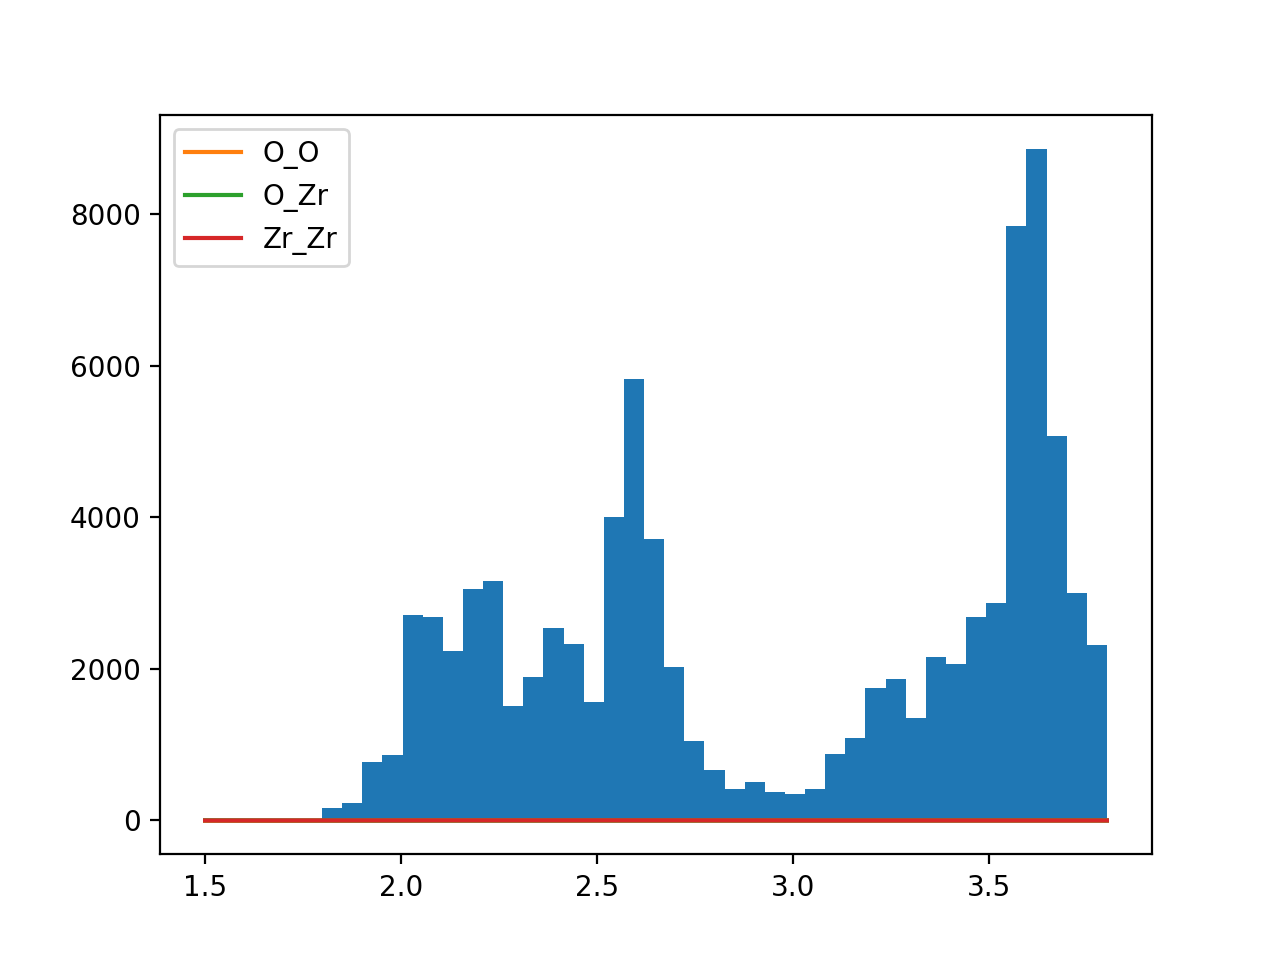

In [8]:

directory = 'train/'
filename = directory + 'train.xyz'
confs = np.load(str(directory + 'confs_cut={:.2f}.npy'.format(r_cut)))

distances = []
M_mean = 0.
M_std = 0.
for c in confs:
    distances += np.linalg.norm(c[:, 0:3], axis=1).tolist()
    M_mean += c.shape[0]
    M_std += c.shape[0] ** 2

M_mean = M_mean / len(confs)
M_std = M_std / len(confs) - M_mean ** 2
print('M is {} += {}'.format(M_mean, M_std))
plt.hist(distances, 40)
plt.show()


# Test GP on the built database

In [9]:
# Directories
train_directory = 'train/'
test_directory = 'train/'

# Parameters
ntr = 100
ntest = 100

print('N train: {}, N test: {}'.format(ntr, ntest))

# Get training configurations and forces from file
tr_confs = np.load(str(train_directory + 'confs_cut={:.2f}.npy'.format(r_cut)))
tr_forces = np.load(str(train_directory + 'forces_cut={:.2f}.npy'.format(r_cut)))
numconfs = len(tr_forces)
ind = np.arange(numconfs)
ind_tot = np.random.choice(ind, size=ntr, replace=False)
tr_confs, tr_forces = tr_confs[ind_tot], tr_forces[ind_tot]

# Get test configurations and forces from file
tst_confs = np.load(str(test_directory + 'confs_cut={:.2f}.npy'.format(r_cut)))
tst_forces = np.load(str(test_directory + 'forces_cut={:.2f}.npy'.format(r_cut)))
numconfs = len(tst_forces)
ind = np.arange(numconfs)
ind_tot = np.random.choice(ind, size=ntest, replace=False)
tst_confs, tst_forces = tst_confs[ind_tot], tst_forces[ind_tot]


N train: 100, N test: 100


In [10]:
m = models.TwoBodyTwoSpeciesModel(elements=elements, noise=noise, sigma=sigma, r_cut=r_cut, theta=r_cut/8.0)

INFO:mff.kernels.twobodykernel:Started compilation of theano two body kernels
INFO:mff.kernels.twobodykernel:Ended compilation of theano two body kernels


In [11]:
m.fit(tr_confs, tr_forces)

In [12]:

# Test the GP performance
print('Testing GP')

gp_forces = np.zeros((ntest, 3))
gp_error = np.zeros((ntest, 3))

for i in np.arange(ntest):
    gp_forces[i, :] = m.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
    gp_error[i, :] = gp_forces[i, :] - tst_forces[i, :]

MAEC = np.mean(abs(gp_error))
MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))
MF = np.mean(np.linalg.norm(tst_forces, axis=1))
RMSE = np.sqrt(np.mean((gp_error) ** 2))

print('RMSE: {:.4}'.format(RMSE))
print('MAEC: {:.4}'.format(MAEC))
print('MAEF : {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))

Testing GP
RMSE: 0.447
MAEC: 0.2515
MAEF : 0.5094 +- 0.5830
Relative MAEF on forces: 0.4330 +- 0.4957


In [13]:
?m.build_grid

In [14]:
grid_start = 1.5
m.build_grid(grid_start, 100)


In [15]:
m.grid

{(0, 0): <mff.interpolation.spline1d.Spline1D at 0x11b4a3e80>,
 (0, 1): <mff.interpolation.spline1d.Spline1D at 0x11b4a3ba8>,
 (1, 1): <mff.interpolation.spline1d.Spline1D at 0x11b4a3e48>}

In [16]:
num_2b = 1000
inds=(0,0)

dists_2b = np.linspace(grid_start, r_cut, num_2b)
plt.plot(dists_2b, m.grid[(0,0)](dists_2b, nu=0), label='O_O')
plt.plot(dists_2b, m.grid[(0,1)](dists_2b, nu=0), label='O_Zr')
plt.plot(dists_2b, m.grid[(1,1)](dists_2b, nu=0), label='Zr_Zr')
plt.legend()
plt.show()
         

In [17]:
# dists_3b = np.linspace(grid_start, r_cut, num_3b)

# z_min, z_max = -.4, .4
# for i in range(0, num_3b, 20):
#     plt.title(dists_3b[i])
    
#     dists_k = np.ones_like(dists_3b) * dists_3b[i]
#     X, Y = np.meshgrid(dists_3b, dists_3b)

#     g_data = grid_c_3b(X.flatten(), Y.flatten(), np.ones_like(X.flatten()) * dists_3b[i]).reshape(num_3b, num_3b)

#     plt.pcolor(dists_3b, dists_3b, -g_data, cmap='RdBu', vmin=z_min, vmax=z_max)
# #     plt.pcolor(dists_3b, dists_3b, -g_data[:,:,i], cmap='RdBu', vmin=z_min, vmax=z_max)
#     plt.colorbar()
#     plt.axis('equal')

#     plt.show()

In [18]:
from mff import calculators

from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.velocitydistribution import Stationary
from ase.md.velocitydistribution import ZeroRotation
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin

from ase import units

In [19]:
# ?calculators.TwoBodyTwoSpecies

In [20]:
atoms  = traj[-1]

calc = calculators.TwoBodyTwoSpecies(r_cut, elements[0], elements[1], grids_2b=m.grid, rep_alpha = 1.5)
atoms = atoms[np.argsort(atoms.get_atomic_numbers())]
atoms.set_calculator(calc)

In [134]:
len(atoms)

96

In [135]:
# Simulation Variables Definition
gamma = 0.001
temp = 400 #K
dt = 1.0  # fs
steps = 1000
t = steps * dt * 10 ** (-3)  # time in ps

# Stationary(atoms)
# ZeroRotation(atoms)
# dyn = VelocityVerlet(atoms, dt * units.fs)
dyn = Langevin(atoms, dt * units.fs, temp * units.kB, 0.05)

# MaxwellBoltzmannDistribution(atoms, 2.0*temp * units.kB)

In [136]:
# ?Langevin

In [137]:
# Define functions to print energy and save the trajectory.

def printenergy(a=atoms):
#     """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))
    


In [138]:
dyn.attach(printenergy, interval=10)

dyn.run(steps)

INFO:mff.calculators:numbers is in system_changes
INFO:mff.calculators:initialize


Energy per atom: Epot = -0.875eV  Ekin = 0.125eV (T=967K)  Etot = -0.750eV
Energy per atom: Epot = -0.998eV  Ekin = 0.232eV (T=1793K)  Etot = -0.766eV
Energy per atom: Epot = -0.996eV  Ekin = 0.218eV (T=1688K)  Etot = -0.777eV
Energy per atom: Epot = -0.989eV  Ekin = 0.192eV (T=1484K)  Etot = -0.797eV
Energy per atom: Epot = -0.994eV  Ekin = 0.175eV (T=1356K)  Etot = -0.819eV
Energy per atom: Epot = -1.044eV  Ekin = 0.214eV (T=1657K)  Etot = -0.830eV
Energy per atom: Epot = -1.053eV  Ekin = 0.210eV (T=1623K)  Etot = -0.843eV
Energy per atom: Epot = -1.070eV  Ekin = 0.218eV (T=1685K)  Etot = -0.852eV
Energy per atom: Epot = -1.090eV  Ekin = 0.218eV (T=1684K)  Etot = -0.872eV
Energy per atom: Epot = -1.090eV  Ekin = 0.206eV (T=1591K)  Etot = -0.884eV
Energy per atom: Epot = -1.137eV  Ekin = 0.231eV (T=1787K)  Etot = -0.906eV
Energy per atom: Epot = -1.143eV  Ekin = 0.222eV (T=1715K)  Etot = -0.922eV
Energy per atom: Epot = -1.133eV  Ekin = 0.208eV (T=1612K)  Etot = -0.925eV
Energy per at